<a href="https://colab.research.google.com/github/patdring/StockTrendForecaster/blob/main/StockPriceLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

epoch:   0 Training loss: 0.4997492631 Validation loss: 2.3033018112
epoch:   1 Training loss: 0.5461318493 Validation loss: 2.3581886441
epoch:   2 Training loss: 0.5790961186 Validation loss: 2.3521757200
epoch:   3 Training loss: 0.5803438028 Validation loss: 2.2041395903
epoch:   4 Training loss: 0.5081369479 Validation loss: 1.9082173854
epoch:   5 Training loss: 0.3754709164 Validation loss: 1.5408597589
epoch:   6 Training loss: 0.2382518848 Validation loss: 1.2478082366
epoch:   7 Training loss: 0.1301607688 Validation loss: 0.9206683990
epoch:   8 Training loss: 0.0501924107 Validation loss: 0.5615364583
epoch:   9 Training loss: 0.0411972230 Validation loss: 0.3467081534
epoch:  10 Training loss: 0.0434847424 Validation loss: 0.3640995612
epoch:  11 Training loss: 0.0323840479 Validation loss: 0.4440995464
epoch:  12 Training loss: 0.0309565440 Validation loss: 0.3905083179
epoch:  13 Training loss: 0.0263254022 Validation loss: 0.2695263475
epoch:  14 Training loss: 0.023603

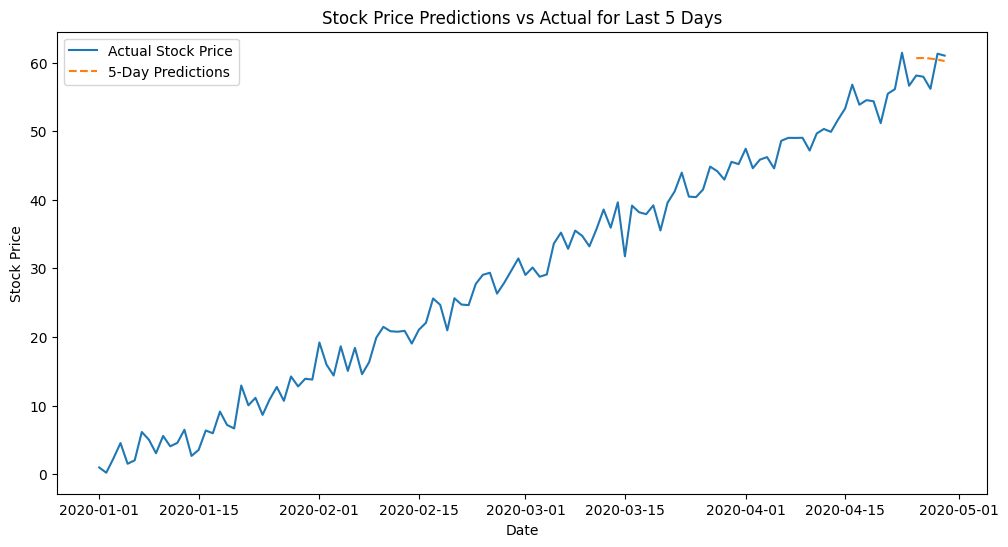

In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import datetime

# Generate simulated data
np.random.seed(42)
num_data_points = 120
stock_prices = np.random.randn(num_data_points) * 2 + np.arange(num_data_points) * 0.5
economic_data = stock_prices * 0.3 + np.random.randn(num_data_points) * 0.5
temperature_data = stock_prices * 0.1 + 20 + np.random.randn(num_data_points) * 5
sentiment_data = stock_prices * 0.05 + np.random.uniform(-1, 1, num_data_points)
combined_data = np.vstack((stock_prices, economic_data, temperature_data, sentiment_data)).T

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_data)
data = torch.from_numpy(scaled_data).float()

# LSTM Model Definition with Updated Parameters
class LSTM(nn.Module):
    def __init__(self, input_size=4, hidden_layer_size=100, output_size=1, num_layers=3, dropout=0.5):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(self.num_layers, 1, self.hidden_layer_size),
                            torch.zeros(self.num_layers, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        input_seq = input_seq.view(1, -1, 4)
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.linear(lstm_out.view(-1, self.hidden_layer_size))
        return predictions[-1]

# Preparing input sequences
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1, 0]
        inout_seq.append((train_seq, train_label))
    return inout_seq

# Split data into training and validation sets
train_size = int(len(data) * 0.8)
val_size = len(data) - train_size
train_data, val_data = torch.split(data, [train_size, val_size])

# Model, loss function, and optimizer with updated parameters
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Gradient Clipping Value
clip_value = 1

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

# Training with early stopping and mini-batch processing
batch_size = 32
train_seq_length = 8  # Updated sequence length

def create_mini_batches(data, batch_size, seq_length):
    inout_seq = create_inout_sequences(data, seq_length)
    return [inout_seq[i:i + batch_size] for i in range(0, len(inout_seq), batch_size)]

# Early Stopping parameters
early_stopping_patience = 10
min_val_loss = np.inf
patience_counter = 0

epochs = 100
for i in range(epochs):
    for batch in create_mini_batches(train_data, batch_size, train_seq_length):
        optimizer.zero_grad()
        batch_loss = 0
        for seq, labels in batch:
            model.hidden_cell = (torch.zeros(model.num_layers, 1, model.hidden_layer_size),
                                 torch.zeros(model.num_layers, 1, model.hidden_layer_size))
            y_pred = model(seq)
            loss = loss_function(y_pred, labels)
            batch_loss += loss
        batch_loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        optimizer.step()
    scheduler.step()

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_losses = []
    with torch.no_grad():
        for seq, labels in create_inout_sequences(val_data, train_seq_length):
            model.hidden_cell = (torch.zeros(model.num_layers, 1, model.hidden_layer_size),
                                 torch.zeros(model.num_layers, 1, model.hidden_layer_size))
            y_pred = model(seq)
            val_loss = loss_function(y_pred, labels)
            val_losses.append(val_loss.item())

    # Avoid division by zero if val_losses is empty
    avg_val_loss = np.mean(val_losses) if len(val_losses) > 0 else np.inf

    print(f'epoch: {i:3} Training loss: {batch_loss.item()/len(batch):10.10f} Validation loss: {avg_val_loss:10.10f}')

    # Early Stopping Check
    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

# Prepare test data for last 5 days
test_inputs = data[-35:, :].tolist()  # Last 30 data points for input, plus 5 for prediction

# Perform predictions for last 5 days
model.eval()
predicted_stock_prices = []
for i in range(5):
    seq = torch.FloatTensor(test_inputs[-30:])  # Convert the last 30 data points to a tensor
    seq = seq.view(1, -1, 4)  # Reshape to [1, seq_len, features]
    with torch.no_grad():
        model.hidden_cell = (torch.zeros(model.num_layers, 1, model.hidden_layer_size),
                             torch.zeros(model.num_layers, 1, model.hidden_layer_size))
        prediction = model(seq).item()  # Get the prediction

        # Append the prediction in the correct format
        next_input = [prediction] + [0] * (4 - 1)  # Assuming other features are zero or placeholder
        test_inputs.append(next_input)  # Append as a list to maintain structure
        predicted_stock_prices.append(prediction)

# Inverse transform the predicted values for last 5 days
predicted_stock_prices = np.array(predicted_stock_prices).reshape(-1, 1)
predicted_stock_prices = scaler.inverse_transform(np.hstack([predicted_stock_prices, np.zeros((predicted_stock_prices.shape[0], 3))]))[:, 0]

# Generate dates for plotting
dates = [datetime.date(2020, 1, 1) + datetime.timedelta(days=i) for i in range(num_data_points)]

# Plot the results with actual stock prices for last 5 days
plt.figure(figsize=(12, 6))
plt.plot(dates, stock_prices, label='Actual Stock Price')
plt.plot(dates[-5:], predicted_stock_prices, label='5-Day Predictions', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Predictions vs Actual for Last 5 Days')
plt.legend()
plt.show()
